In [ ]:
# Finding Obama in OpenCV by Hadi Abdelmawla
# in this what I do is I take the template images take the face of each one then run it through a skin detection program and mask the rest of the image in order to show only the face
# then I run the masked image through a filter that masks all images that aren't in the brown range 
# I do the same for the images in the folder find the face mask the skin then filter it 
# I then compare the templates to the folders via a histogram with the thinking that the darker the skin tone the better histogram match since there will be more pixels of similar colors 
# I then use the images that score above the templates being scored against one another giving me only images of darker skin tone people
# then I take the masked face image of the template and folder image that scored above in the template matching and use a template scoring then take the largest value score of the template matching
# I take the avg of all the scores in the folder create the IQR then use that to detect on outliers
# I calculate if there are any outliers that are outside the outerfence and those images are obama 
# Lastly, I have only ran this against folder D for fear of crashing the server  and left the output of folder D untouched but have included the lines of code in order to run for all folders

In [306]:
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [307]:
#  Main code starts here
#  Location and loading Face Cascade XML
OPENCV_PATH = "/usr/local/lib/python3.6/dist-packages/cv2/data"
faceXML = os.path.join(OPENCV_PATH,'haarcascade_frontalface_default.xml')
faceCascade = cv2.CascadeClassifier(faceXML)

obamabaseDir = "/home/CV/FaceData"
baseDir = "/home/CV/FaceData_Test"
folderList = ['A','B','C','D','E']
folderPathList = [os.path.join(baseDir,folder) for folder in folderList]



In [567]:
ls /home/CV/FaceData/

A/  B/  C/  D/  E/  ObamaTemplate/


In [309]:
def process_images_from_directory(faceCascade, directory, scaleFactor=1.1, minNeighbors=8): # process the images from the directory and create faces for them
    imageDictionary = dict() 
    for directoryPath, directoryNames, fileNames in os.walk(directory):
        for fileName in fileNames:
            imageFile = os.path.join(directoryPath, fileName) 
            # Reads image into RGB for histogram comparison
            img = cv2.imread(imageFile)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces = faceCascade.detectMultiScale(img_gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
            print(faces)
            print(imageFile)
            imageDictionary[fileName] = (img_gray,img_rgb, faces)  
    return imageDictionary

def process_image_from_list(faceCascade, image_list, scaleFactor=1.1, minNeighbors=8, minSize=(40,40), maxSize=(400,400)): # process the images from the list
    imageList = list()
    for imageFile in image_list:
        # Reads image into RGB for histogram comparison
        img = cv2.imread(imageFile)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = faceCascade.detectMultiScale(img_rgb, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        imageList.append((imageFile, img_rgb, faces))
    
    return imageList

<CascadeClassifier 0x7f84dc8d5d10>
[[ 33  53 156 156]]


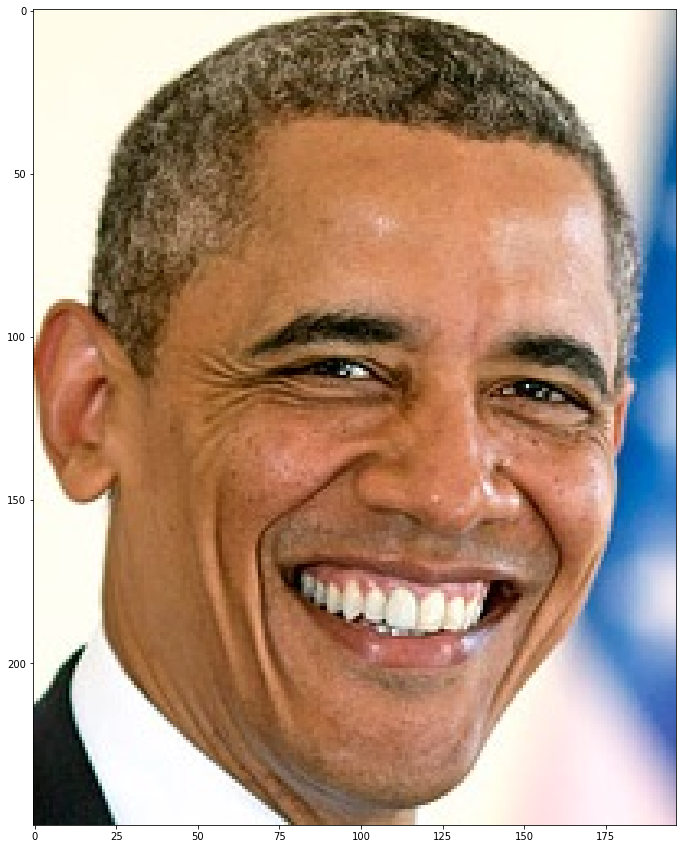

[[2962.]
 [1864.]
 [ 977.]
 [ 735.]
 [ 607.]
 [ 356.]
 [ 191.]
 [ 188.]]


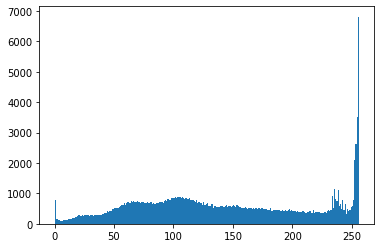

In [310]:
# this is a test portion of the code to just find a face of one template then create a histogram for it please disregard
templateDir = '/home/CV/FaceData/ObamaTemplate/ObamaTemplate2.jpg'

da_img = cv2.imread(templateDir)
daimg_rgb = cv2.cvtColor(da_img, cv2.COLOR_BGR2RGB)

daimg_gray = cv2.cvtColor(da_img, cv2.COLOR_BGR2GRAY)


print(faceCascade)

da_faces = faceCascade.detectMultiScale(daimg_gray, 1.1, 8)
print(da_faces)

o_y, o_x, o_h, o_w = da_faces[0]
obama_face_template = daimg_gray[o_y:o_y+o_h, o_x:o_x+o_w]
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(1, 1, 1)
ax.imshow(daimg_rgb)
plt.show()
hist0 = cv2.calcHist([obama_face_template], [0], None, [8], [150,256])
print(hist0)
plt.hist(daimg_rgb.ravel(),256,[0,256]); plt.show()


In [311]:
#This is where the real fun in coding begins
# I create the function to detect the skin color 
import numpy as np

def skinColor_mask_hist (da_img): # this where i take the image passed and mask it for only brown skin colors
    skin_mask_dict = dict()
    rgb_mask_dict = dict()

    imageYCrCb = cv2.cvtColor(da_img,cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb) # I detect the region in which there is skin
    daimg_rgb = cv2.cvtColor(da_img, cv2.COLOR_BGR2RGB)
    skinYCrCb = cv2.bitwise_and(daimg_rgb, daimg_rgb, mask = skinRegionYCrCb) # then mask the original image to only show skin
    skin_mask_dict = skinYCrCb
    lower = np.array([190, 0, 0], dtype = "uint8")
    upper = np.array([205,255,255], dtype = "uint8") # I then define the limits of brown that I want in RGB form
    mask = cv2.inRange(skinYCrCb, lower, upper)
    output = cv2.bitwise_and(skinYCrCb, skinYCrCb, mask = mask) # i then mask the masked skin image to only show pixels that satisfy the limits of brown
    rgb_mask_dict = output
    return skin_mask_dict, rgb_mask_dict


In [312]:
import glob
def read_image_files(image_path, conversion=cv2.COLOR_BGR2RGB): # these two functions are from the pokemon assignment
    image_files = glob.glob(os.path.join(image_path, '*')) #function in order to convert the images pass through the image path and conversion
    image_list = [(os.path.basename(f),cv2.imread(f,conversion)) for f in image_files]
    image_dict = {file:image for (file,image) in image_list}
    return image_dict

def generate_histogram(image, number_bins=8):
    histogram_dict = dict()
    #for filename in image_dict: # function to take the images and create histograms for each one 
    #image = image_dict[filename]
    hist0 = cv2.calcHist([image], [0], None, [number_bins], [0,256])
    hist1 = cv2.calcHist([image], [1], None, [number_bins], [0,256])
    hist2 = cv2.calcHist([image], [2], None, [number_bins], [0,256])
    overall_hist = np.concatenate([hist0,hist1,hist2]).ravel()
    hist = overall_hist / overall_hist.sum()
    histogram_dict = hist
    return histogram_dict

obama_temp_directory = '/home/CV/FaceData/ObamaTemplate/'
obama_temp_dict = read_image_files(obama_temp_directory) # I then take all the obama template images and run them through the above functions
mask_rgb_obama = dict()
for filename in obama_temp_dict:      
    img = obama_temp_dict[filename]
    mask_rgb_obama[filename] = skinColor_mask_hist(img)

masked_hist_obama = dict()
for filename in mask_rgb_obama:      
    img = mask_rgb_obama[filename][1]

    masked_hist_obama[filename] = generate_histogram(img)


In [313]:
imgbaseDir_D = "/home/CV/FaceData/D" # here I create the image directory for all folders and get the images masked skin image then masked brown img then create a hist for all of them a whole lot of copy and paste
imgbaseDir_A = "/home/CV/FaceData/A"
imgbaseDir_B = "/home/CV/FaceData/B"
imgbaseDir_C = "/home/CV/FaceData/C"
imgbaseDir_E = "/home/CV/FaceData/E"
d_folderDict = read_image_files(imgbaseDir_D)
a_folderDict = read_image_files(imgbaseDir_A)
b_folderDict = read_image_files(imgbaseDir_B)
c_folderDict = read_image_files(imgbaseDir_C)
e_folderDict = read_image_files(imgbaseDir_E)
d_mask_rgb = dict()
a_mask_rgb = dict()
b_mask_rgb = dict()
c_mask_rgb = dict()
e_mask_rgb = dict()
for filename in d_folderDict:      
    img = d_folderDict[filename]
    d_mask_rgb[filename] = skinColor_mask_hist(img)
d_masked_hist = dict()
for filename in d_mask_rgb: 
    img = d_mask_rgb[filename][1]
    d_masked_hist[filename] = generate_histogram(img)

for filename in a_folderDict:      
    img = a_folderDict[filename]
    a_mask_rgb[filename] = skinColor_mask_hist(img)
a_masked_hist = dict()
for filename in a_mask_rgb: 
    img = a_mask_rgb[filename][1]
    a_masked_hist[filename] = generate_histogram(img)
    
for filename in b_folderDict:      
    img = b_folderDict[filename]
    b_mask_rgb[filename] = skinColor_mask_hist(img)
b_masked_hist = dict()
for filename in b_mask_rgb: 
    img = b_mask_rgb[filename][1]
    b_masked_hist[filename] = generate_histogram(img)
    
for filename in c_folderDict:      
    img = c_folderDict[filename]
    c_mask_rgb[filename] = skinColor_mask_hist(img)
c_masked_hist = dict()
for filename in c_mask_rgb: 
    img = c_mask_rgb[filename][1]
    c_masked_hist[filename] = generate_histogram(img)
    
for filename in e_folderDict:      
    img = e_folderDict[filename]
    e_mask_rgb[filename] = skinColor_mask_hist(img)
e_masked_hist = dict()
for filename in e_mask_rgb: 
    img = e_mask_rgb[filename][1]
    e_masked_hist[filename] = generate_histogram(img)


In [376]:
def compare_histogram(image_name, target_hist_base, class_histogram_dict): # same function from pokemon
    results_dict = dict()
    for (methodName, method, reverse) in OPENCV_METHODS:
        results = {k : cv2.compareHist(target_hist_base, hist, method) for (k,hist) in sorted(class_histogram_dict.items())} #compare the histograms pass in the targets and class
        results = sorted([(v, k) for (k, v) in results.items()], reverse = reverse)
        results_dict[methodName] = results
        
    return results_dict
def compare_hist_template(masked_hist): # here is where I compare the templates against each other
    template_scores = dict()
    for filename in masked_hist:
        if(filename == 'ObamaTemplate0.jpg'):
            continue
        template_scores[filename] = (cv2.compareHist(masked_hist_obama['ObamaTemplate0.jpg'], masked_hist[filename], cv2.HISTCMP_INTERSECT))
    return template_scores


temp_scores= dict()

for filename in masked_hist_obama:
    
    if(filename == 'ObamaTemplate0.jpg'):
        continue
    temp_scores = compare_hist_template(masked_hist_obama) # score the templates against each other
    
print(temp_scores)
d_scores= dict() # I then score the hist of the folders against obama and take the score back
for filename in d_masked_hist:    
    d_scores = compare_hist_template(d_masked_hist)    
print(d_scores)

a_scores= dict()
for filename in a_masked_hist:    
    a_scores = compare_hist_template(a_masked_hist)    
print(a_scores)

b_scores= dict()
for filename in b_masked_hist:    
    b_scores = compare_hist_template(b_masked_hist)    
print(b_scores)

c_scores= dict()
for filename in c_masked_hist:    
    c_scores = compare_hist_template(c_masked_hist)    
print(c_scores)

e_scores= dict()
for filename in e_masked_hist:    
    e_scores = compare_hist_template(e_masked_hist)    
print(e_scores)



{'ObamaTemplate1.jpg': 0.9535141796368407, 'ObamaTemplate2.jpg': 0.9747322999755852}
{'img_681.jpg': 0.9551180698326789, 'img_570.jpg': 0.9682892685632396, 'img_850.jpg': 0.974358246770862, 'img_9.jpg': 0.9608349636546336, 'img_842.jpg': 0.9469275194014699, 'img_886.jpg': 0.9483963047241559, 'img_734.jpg': 0.9635738444994786, 'img_655.jpg': 0.9613295297685909, 'img_844.jpg': 0.9455498179304413, 'img_939.jpg': 0.9485832206373743, 'img_775.jpg': 0.9511958642469835, 'img_896.jpg': 0.9699567094939994, 'img_562.jpg': 0.9467289132408041, 'img_534.jpg': 0.9609680536450469, 'img_549.jpg': 0.9452694206408978, 'img_686.jpg': 0.9684834743966348, 'img_673.jpg': 0.9478655376251481, 'img_626.jpg': 0.9699621570762247, 'img_867.jpg': 0.9642311336210696, 'img_600.jpg': 0.9665653061383637, 'img_847.jpg': 0.9603737276047468, 'img_851.jpg': 0.9734504765365273, 'img_846.jpg': 0.9470824014001664, 'img_53.jpg': 0.9635843295909581, 'img_711.jpg': 0.9511220426065847, 'img_93.jpg': 0.9543479158564878, 'img_999.

In [377]:
from statistics import mean # I now create and average for the scores and then find the ones that score above the average of the template hists
def calc_avg_score(score_dict):
    my_list = []
    da_mean = mean(score_dict[filename] for filename in score_dict)
    print(da_mean) 
    return (da_mean)

def greater_than_avg(avg, img_dict):
    score_well= dict()
    for filename in img_dict:
        score = img_dict[filename]
        if score>avg:
            score_well[filename] = score
    return score_well
da_score = calc_avg_score(temp_scores)
d_above_avg = dict()
a_above_avg = dict()
b_above_avg = dict()
c_above_avg = dict()
e_above_avg = dict()

d_above_avg = greater_than_avg(da_score, d_scores)
a_above_avg = greater_than_avg(da_score, a_scores)
b_above_avg = greater_than_avg(da_score, b_scores)
c_above_avg = greater_than_avg(da_score, c_scores)
e_above_avg = greater_than_avg(da_score, e_scores)
print(da_score)
print(d_above_avg)


0.964123239806213
0.964123239806213
{'img_570.jpg': 0.9682892685632396, 'img_850.jpg': 0.974358246770862, 'img_896.jpg': 0.9699567094939994, 'img_686.jpg': 0.9684834743966348, 'img_626.jpg': 0.9699621570762247, 'img_867.jpg': 0.9642311336210696, 'img_600.jpg': 0.9665653061383637, 'img_851.jpg': 0.9734504765365273, 'img_999.jpg': 0.9645437655854039}


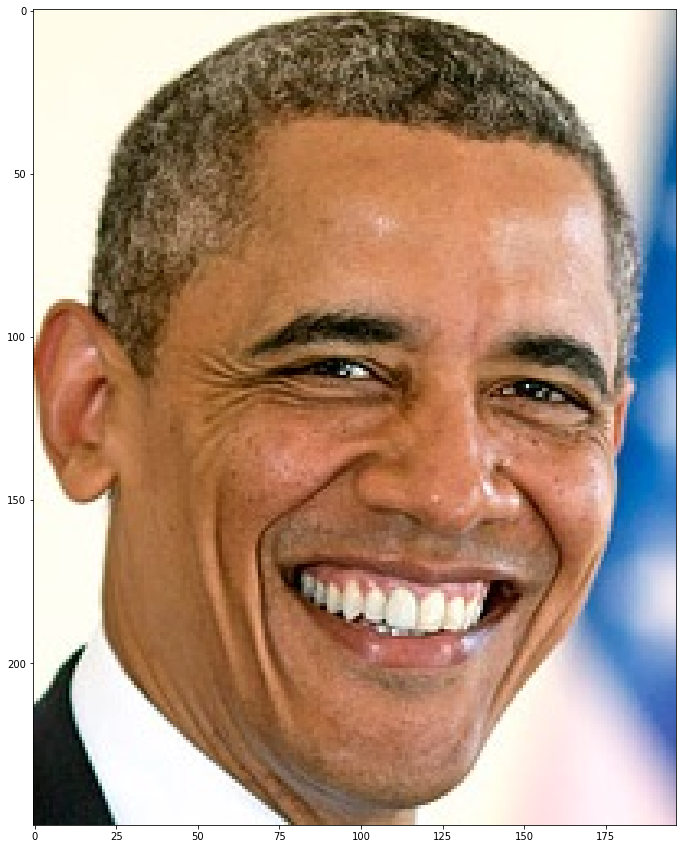

In [382]:
#another test to find obamas face in the template please disregard
for filename in obama_temp_dict:      
    img = obama_temp_dict[filename]
    testimg_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(1, 1, 1)
ax.imshow(testimg_rgb)

In [415]:
for filename in d_above_avg: # I create the face for all the images in the folder here
    img = d_folderDict[filename]
    face = faceCascade.detectMultiScale(img, 1.1, 8)
    if face == ():
        print ('h') # if it doesn't give me a face then just toss it out
        continue
    o_y, o_x, o_h, o_w = faces[0]
    d_face_template = img[o_y:o_y+o_h, o_x:o_x+o_w]
for filename in obama_temp_dict:
    image = obama_temp_dict[filename]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


h


In [ ]:
# here I take the files and crop them then did a test run with the match template but the real match template is below
for filename in obama_temp_dict:
    images = obama_temp_dict[filename]#[0]
    image = mask_rgb_obama[filename][0]
    da_image = mask_rgb_obama[filename][0]
    face = faceCascade.detectMultiScale(image, 1.1, 8)
    fig = plt.figure(figsize = (15,15))
    imageYCrCb = cv2.cvtColor(image,cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    x,y,w,h = cv2.boundingRect(thresh)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    b,g,r = cv2.split(ROI)
    alpha = np.ones(b.shape, dtype=b.dtype) * 250
    ROI = cv2.merge([b,g,r,alpha])
    for file in d_above_avg:
        img = d_mask_rgb[file][0]
        ax.imshow(img)
        score0 = cv2.matchTemplate(img, da_image, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(score0)
        print(max_val)
        print(file)
        print(filename)
temp_score_dict = dict()


0.632390022277832
img_570.jpg
ObamaTemplate1.jpg
0.6423618793487549
img_850.jpg
ObamaTemplate1.jpg
0.7353900074958801
img_896.jpg
ObamaTemplate1.jpg
0.6337149143218994
img_686.jpg
ObamaTemplate1.jpg
0.6039470434188843
img_626.jpg
ObamaTemplate1.jpg
0.524702250957489
img_867.jpg
ObamaTemplate1.jpg
0.6470164656639099
img_600.jpg
ObamaTemplate1.jpg
0.6497508883476257
img_851.jpg
ObamaTemplate1.jpg
0.7294257879257202
img_999.jpg
ObamaTemplate1.jpg
0.576286256313324
img_570.jpg
ObamaTemplate0.jpg
0.5779377818107605
img_850.jpg
ObamaTemplate0.jpg
0.5924383401870728
img_896.jpg
ObamaTemplate0.jpg
0.5285885334014893
img_686.jpg
ObamaTemplate0.jpg
0.5628489255905151
img_626.jpg
ObamaTemplate0.jpg
0.49991533160209656
img_867.jpg
ObamaTemplate0.jpg
0.5650503635406494
img_600.jpg
ObamaTemplate0.jpg
0.5781931281089783
img_851.jpg
ObamaTemplate0.jpg
0.7245155572891235
img_999.jpg
ObamaTemplate0.jpg
0.5941829681396484
img_570.jpg
ObamaTemplate2.jpg
0.5992900133132935
img_850.jpg
ObamaTemplate2.jpg
0.

In [564]:
temp_score_dict = dict()
# here is the function that calculates the match template and returns the max val and average of the max val for all three tests 
name0 = 'ObamaTemplate0.jpg'
def template_score_avg(folderImage, temp_dict):
    score0 = cv2.matchTemplate(folderImage, temp_dict[name0][0], cv2.TM_CCORR_NORMED)
    score1 = cv2.matchTemplate(folderImage, mask_rgb_obama['ObamaTemplate1.jpg'][0], cv2.TM_CCORR_NORMED)
    score2 = cv2.matchTemplate(folderImage, mask_rgb_obama['ObamaTemplate2.jpg'][0], cv2.TM_CCORR_NORMED)
    min_val0, max_val0, min_loc0, max_loc0 = cv2.minMaxLoc(score0)
    min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(score1)
    min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(score2)
    sumOfScores = max_val0 + max_val1 + max_val2
    average = sumOfScores / 3
    return average

score_dict = dict() # here is where I take the images and pass them through template matching and creat a list of average values
mylist = []
for file in d_above_avg:
        img = d_mask_rgb[file][0]
        score_dict[file] = template_score_avg(img, mask_rgb_obama)
        scores_of_template = score_dict[file]
        mylist.append(scores_of_template)
print(score_dict)

ascore_dict = dict() 
amylist = []
for file in a_above_avg:
        img = a_mask_rgb[file][0]
        ascore_dict[file] = template_score_avg(img, mask_rgb_obama)
        ascores_of_template = ascore_dict[file]
        amylist.append(ascores_of_template)

bscore_dict = dict() 
bmylist = []
for file in b_above_avg:
        img = b_mask_rgb[file][0]
        bscore_dict[file] = template_score_avg(img, mask_rgb_obama)
        bscores_of_template = bscore_dict[file]
        bmylist.append(bscores_of_template)


cscore_dict = dict() 
cmylist = []
for file in c_above_avg:
        img = c_mask_rgb[file][0]
        cscore_dict[file] = template_score_avg(img, mask_rgb_obama)
        cscores_of_template = cscore_dict[file]
        cmylist.append(cscores_of_template)


escore_dict = dict() 
emylist = []
for file in e_above_avg:
        img = e_mask_rgb[file][0]
        escore_dict[file] = template_score_avg(img, mask_rgb_obama)
        escores_of_template = escore_dict[file]
        emylist.append(escores_of_template)




{'img_570.jpg': 0.6009530822436014, 'img_850.jpg': 0.6065298914909363, 'img_896.jpg': 0.649066428343455, 'img_686.jpg': 0.5715057055155436, 'img_626.jpg': 0.5823912421862284, 'img_867.jpg': 0.5093639194965363, 'img_600.jpg': 0.6006502310434977, 'img_851.jpg': 0.6092353463172913, 'img_999.jpg': 0.7335719267527262}


I can not believe I have finally found Obama I am crying tears of relief


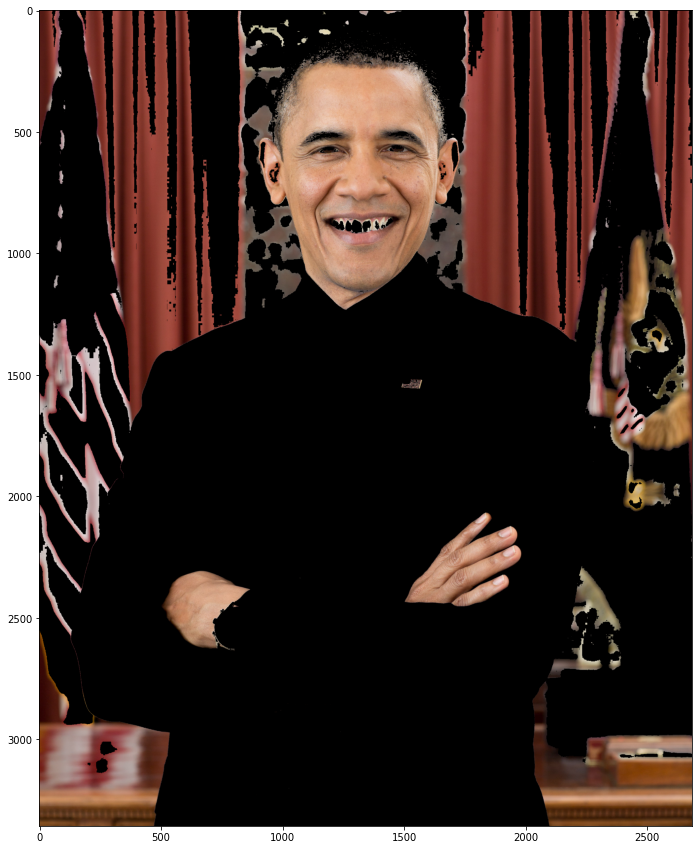

In [566]:
#here is where i take the sum of lists and create the quartiles and IQR then use that to detect outliers and find obama
the_sum = sum(mylist)
length = len(mylist)
the_avg = the_sum/length
Q1 = np.percentile(mylist, 25, interpolation = 'midpoint') 
Q3 = np.percentile(mylist, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
IQR_range = IQR * 2
outer_fence = IQR_range + the_avg
for value in mylist:
    if value > outer_fence: #I then take if the value is greater then the barrier for outliers then find it in the directory and print it because it is obama
        for filename in score_dict:
            if value == score_dict[filename]:
                img = d_mask_rgb[filename][0]
                fig = plt.figure(figsize = (15, 15))
                ax = fig.add_subplot(1, 1, 1)
                ax.imshow(img)
                print('I can not believe I have finally found Obama I am crying tears of relief')
                
the_sum = sum(amylist)
length = len(amylist)
the_avg = the_sum/length
Q1 = np.percentile(amylist, 25, interpolation = 'midpoint') 
Q3 = np.percentile(amylist, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
IQR_range = IQR * 2
outer_fence = IQR_range + the_avg
for value in amylist:
    if value > outer_fence:
        for filename in ascore_dict:
            if value == ascore_dict[filename]:
                img = a_mask_rgb[filename][0]
                fig = plt.figure(figsize = (15, 15))
                ax = fig.add_subplot(1, 1, 1)
                ax.imshow(img)
                print('I can not believe I have finally found Obama I am crying tears of relief')

the_sum = sum(bmylist)
length = len(bmylist)
the_avg = the_sum/length
Q1 = np.percentile(bmylist, 25, interpolation = 'midpoint') 
Q3 = np.percentile(bmylist, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
IQR_range = IQR * 2
outer_fence = IQR_range + the_avg
for value in bmylist:
    if value > outer_fence:
        for filename in bscore_dict:
            if value == bscore_dict[filename]:
                img = b_mask_rgb[filename][0]
                fig = plt.figure(figsize = (15, 15))
                ax = fig.add_subplot(1, 1, 1)
                ax.imshow(img)
                print('I can not believe I have finally found Obama I am crying tears of relief')
                
the_sum = sum(cmylist)
length = len(cmylist)
the_avg = the_sum/length
Q1 = np.percentile(cmylist, 25, interpolation = 'midpoint') 
Q3 = np.percentile(cmylist, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
IQR_range = IQR * 2
outer_fence = IQR_range + the_avg
for value in cmylist:
    if value > outer_fence:
        for filename in cscore_dict:
            if value == cscore_dict[filename]:
                img = c_mask_rgb[filename][0]
                fig = plt.figure(figsize = (15, 15))
                ax = fig.add_subplot(1, 1, 1)
                ax.imshow(img)
                print('I can not believe I have finally found Obama I am crying tears of relief')
                
                
the_sum = sum(emylist)
length = len(emylist)
the_avg = the_sum/length
Q1 = np.percentile(emylist, 25, interpolation = 'midpoint') 
Q3 = np.percentile(emylist, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1 
IQR_range = IQR * 2
outer_fence = IQR_range + the_avg
for value in emylist:
    if value > outer_fence:
        for filename in escore_dict:
            if value == escore_dict[filename]:
                img = e_mask_rgb[filename][0]
                fig = plt.figure(figsize = (15, 15))
                ax = fig.add_subplot(1, 1, 1)
                ax.imshow(img)
                print('I can not believe I have finally found Obama I am crying tears of relief')

In [484]:
for filename in obama_temp_dict:
    da_images = mask_rgb_obama[filename][0]
    for file in obama_temp_dict:
        da_image = mask_rgb_obama[file][0]
        score0 = cv2.matchTemplate(da_image, da_images, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(score0)
        print(max_val)
        print(file)
        print(filename)
    

1.0
ObamaTemplate1.jpg
ObamaTemplate1.jpg
0.8845667839050293
ObamaTemplate0.jpg
ObamaTemplate1.jpg
0.8796581029891968
ObamaTemplate2.jpg
ObamaTemplate1.jpg
0.8845667839050293
ObamaTemplate1.jpg
ObamaTemplate0.jpg
0.9999999403953552
ObamaTemplate0.jpg
ObamaTemplate0.jpg


error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/templmatch.cpp:1109: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'matchTemplate'


<CascadeClassifier 0x7f8540338250>
['/home/CV/FaceData/A/img_217.jpg', '/home/CV/FaceData/B/img_99.jpg', '/home/CV/FaceData/C/img_62.jpg', '/home/CV/FaceData/D/img_999.jpg', '/home/CV/FaceData/E/img_733.jpg']


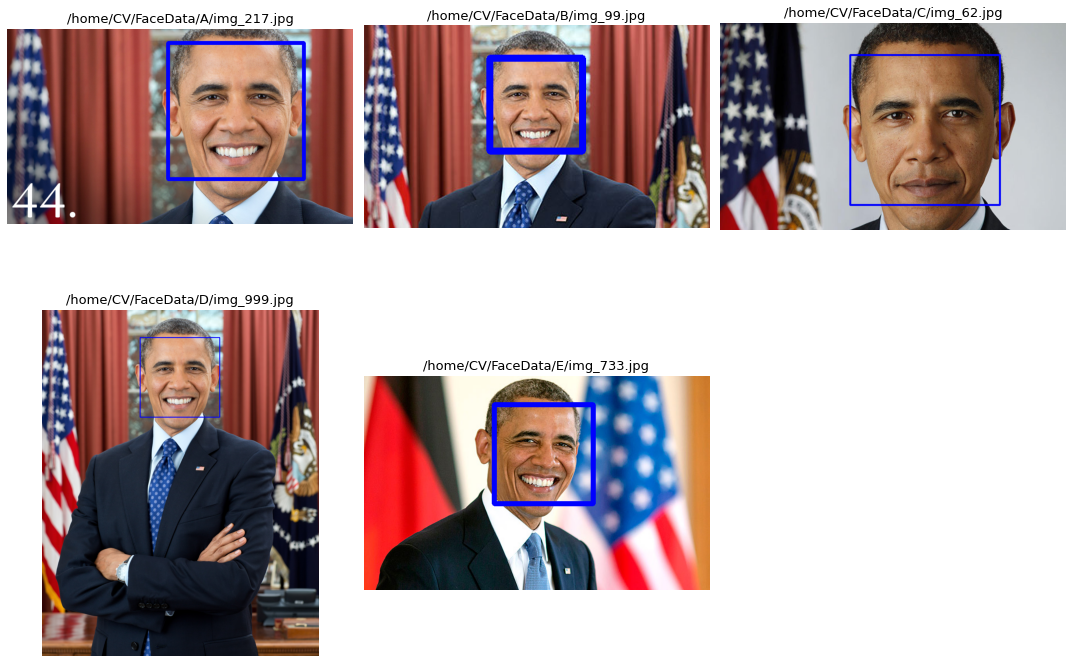

In [52]:
# I really miss Obama
ground_truth = [("A", "img_217.jpg"), ("B", "img_99.jpg"), ("C", "img_62.jpg"), ("D", "img_999.jpg"), ("E", "img_733.jpg")]

obama_list = [os.path.join(obamabaseDir,folderName,imageName) for (folderName,imageName) in ground_truth]
print(faceCascade)
print(obama_list)
obama_image_list = process_image_from_list(faceCascade, obama_list)


fig = plt.figure(figsize = (15, 15))

#  This loop cycles through 'folderPathList' and calls out the 3 functions above and produces
#  the images with a box around the faces that had the highest score from the histogram comparison
for index, (imageFile,imageData,faces) in enumerate(obama_image_list):
    
    # Assume only one face for obama photos... could be more 
    x = faces[0][0]
    y = faces[0][1]
    w = faces[0][2]
    h = faces[0][3]
    
    #  Obtaining the X and Y coordinates and face cascade's region of interest's width and height
    #  and assigning them as single letter variables since the brackets and parantheses became too
    #  confusing to maintain as a direct argument into 'cv2.rectangle()'
    #x = oneFaceDictionary[imgMatchList[folderPathList.index(folderPath)]][1][0][0]
    #y = oneFaceDictionary[imgMatchList[folderPathList.index(folderPath)]][1][0][1]
    #w = oneFaceDictionary[imgMatchList[folderPathList.index(folderPath)]][1][0][2]
    #h = oneFaceDictionary[imgMatchList[folderPathList.index(folderPath)]][1][0][3]
    
    #  Creating the title string on a separate line since it was easier to maintain
    titleString =  imageFile
    
    #  Creating the box around the face on the image with the best histogram comparison score
    #  The line may show to be excessively large on a few images because anything smaller than 5
    #  was difficult to see on high resolution images
    boxedFace = cv2.rectangle(imageData, (x, y), (x+w, y+h), (0,0,255), 7)
    ax = fig.add_subplot(3, 3, index + 1)
    ax.imshow(imageData)
    plt.title(titleString, fontsize = 13)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [88]:
# this runs face detection with the settings across all images in double dictionary
#imageDictionary = {folderName : process_images_from_directory(faceCascade, os.path.join(baseDir,folderName)) for folderName in folderList}
#process_images_from_directory
#print(imageDictionary['A']['img_200.jpg'][2])
ObamaDictionary = {folderName : process_images_from_directory(faceCascade, os.path.join(baseDir,folderName)) for folderName in ['ObamaTemplate']}
print(ObamaDictionary['ObamaTemplate']['ObamaTemplate0.jpg'][2])

[[ 97 227 707 707]]
h
/home/CV/FaceData_Test/ObamaTemplate/ObamaTemplate1.jpg
()
h
/home/CV/FaceData_Test/ObamaTemplate/ObamaTemplate0.jpg
[[ 33  53 156 156]]
h
/home/CV/FaceData_Test/ObamaTemplate/ObamaTemplate2.jpg
()


In [53]:
gray_obama_image, rgb_obama_image, obama_face = obamaDictionary['ObamaTemplate']['ObamaTemplate0.jpg']
print(obamaDictionary['ObamaTemplate']['ObamaTemplate0.jpg'])
print(obama_face)
print(gray_obama_image)
print('pp')
print(rgb_obama_image)
o_y, o_x, o_h, o_w = obama_face[0]
obama_face_template = grey_obama_image[o_y-20:o_y+h+20, o_x-20:o_x+w+20]
fig = plt.figure(figsize = (15,15))

ax = fig.add.subplot(1,1,1)
ax.imshow(obama_face_template)
plt.show()

(array([[101, 101, 103, ...,  79,  79,  78],
       [102, 102, 104, ...,  77,  78,  79],
       [101, 102, 104, ...,  77,  78,  78],
       ...,
       [ 26,  28,  29, ...,  58,  64,  67],
       [ 27,  28,  29, ...,  53,  58,  59],
       [ 27,  28,  29, ...,  50,  54,  56]], dtype=uint8), array([[[ 63, 112, 145],
        [ 63, 112, 145],
        [ 67, 113, 147],
        ...,
        [ 45,  86, 132],
        [ 45,  86, 132],
        [ 44,  85, 131]],

       [[ 64, 113, 146],
        [ 64, 113, 146],
        [ 68, 114, 148],
        ...,
        [ 43,  84, 130],
        [ 44,  85, 131],
        [ 45,  86, 132]],

       [[ 63, 112, 145],
        [ 64, 113, 146],
        [ 68, 114, 148],
        ...,
        [ 45,  83, 132],
        [ 46,  84, 133],
        [ 46,  84, 133]],

       ...,

       [[ 25,  25,  35],
        [ 27,  27,  37],
        [ 28,  28,  38],
        ...,
        [ 51,  58,  77],
        [ 54,  65,  85],
        [ 56,  68,  90]],

       [[ 26,  26,  36],
        [ 

IndexError: tuple index out of range

In [16]:
scale_size = (60,60)
results_list = list()
for folder in imageDictionary:
    for test_file in imageDictionary[folder]:
        #print(folder, test_file, imageDictionary[folder][test_file])
        test_gray, test_rgb, test_faces = imageDictionary[folder][test_file]
        
        for (y,x,w,h) in list(test_faces):
            #print (test_file,face)
            face_to_identify = test_gray[y:y+h, x:x+w]
            #print (face_to_identify)
            #resized_obama_face = cv2.resize(obama_face_template, scale_size, interpolation = cv2.INTER_AREA)
            #resized_test_face = cv2.resize(face_to_identify, scale_size, interpolation = cv2.INTER_AREA)
            
            resized_obama_face = cv2.resize(obama_face_template, (o_h, o_w), interpolation = cv2.INTER_AREA)
            resized_test_face = cv2.resize(face_to_identify, (o_h, o_w), interpolation = cv2.INTER_AREA)
            
            score0 = cv2.matchingTemplate(resized_obama_face, resized_test_face, cv2.TM_CCORR_NORMED)
            score1 = cv2.matchingTemplate(resized_obama_face, resized_test_face, cv2.TM_SQDIFF_NORMED)
            print (folder, test_file, score)
            
            results_list.append(folder, test_file, score0[0][0], score1[0][0])

NameError: name 'obama_face_template' is not defined

In [9]:
# Draw rectangles of all faces in double dictionary, this will change images

for index, folderName in enumerate(folderList):
    for imageName in imageDictionary[folderName]:
        # Stored in double dictionary is the tuple of (imageData, FaceData)
        # faceData is a list of all faces found : x,y coordinate with w,h being width and height
        imageData = imageDictionary[folderName][imageName][0]
        faceData = imageDictionary[folderName][imageName][1]
        for (x,y,w,h) in faceData:        
            cv2.rectangle(imageData,(x,y),(x+w,y+h),(255,0,0),2) #plotting on Color images


    


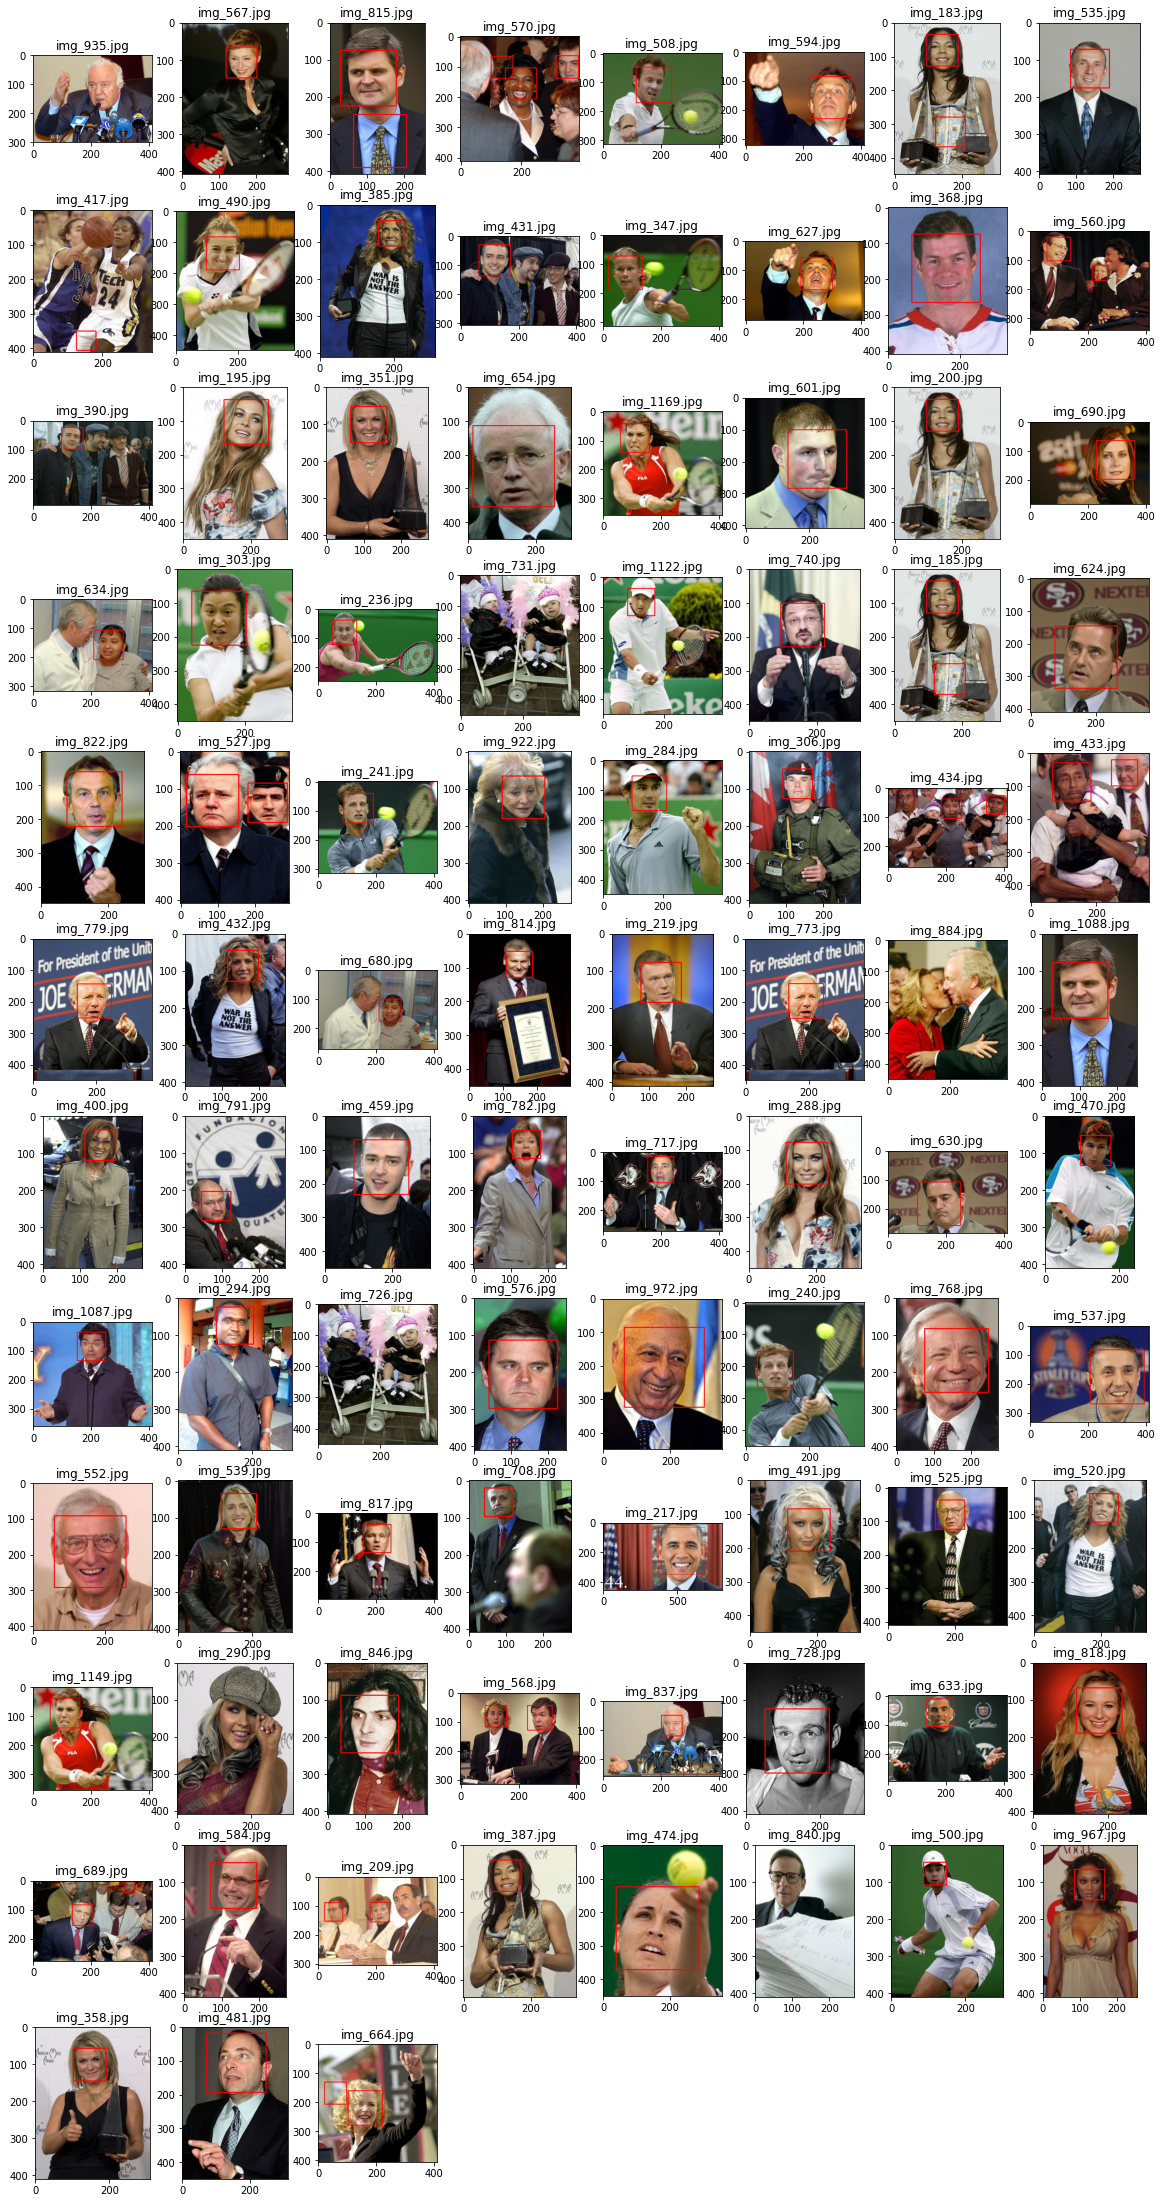

In [11]:
            
# this plots one directory 
plt.figure(figsize=(20,100))
folderName = 'A'
for index, imageName in enumerate(imageDictionary[folderName]):
    imageData = imageDictionary[folderName][imageName][0]
    plt.subplot(30,8,index+1)
    plt.imshow(imageData)
    plt.title(imageName)